<a href="https://colab.research.google.com/github/Anshuman-37/Summer_Dissertation/blob/main/First_Model_Try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Import Files

In [3]:
import os
import re
import nibabel as nib
import numpy as np
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, LazyConv3d , MaxPool3d, Module, Softmax, BatchNorm3d, Dropout, Conv3d, MSELoss
from torch.optim import Adam, SGD
from torchsummary import summary
from tqdm import tqdm

1.11.0+cu113
True


In [4]:
torch.cuda.empty_cache()

##### Uniziping the Data

In [ ]:
!unzip /content/Raw\ Files.zip -d /content/
!unzip /content/Baseline.zip -d /content/

##### Data Loading 

In [21]:
def get_mri_data(path_mri):
    '''Returns a list containing the path of MRI DATA'''
    path = path_mri;
    regex = re.compile(r'__MPR.*') ; fileRegex1 = re.compile(r'(WIP)*T13D'); mri_data_path = []; 
    # Iterating over Directories 
    for subdir, dirs, files in os.walk(path):
        for file in files:
            # Storing the path of Data
            if regex.search(file) == None:
                if fileRegex1.search(file): mri_data_path.append(os.path.join(subdir, file));
    return mri_data_path;

def get_asl_data(path_asl):
    '''Returns a list containing the path of ASL DATA'''
    asl_path = path_asl;
    asl_regex = re.compile(r'oxasl_dist.*'); asl_data_path = [];
    # Iterating over directories
    for subdir, dirs, files in os.walk(asl_path):
        # Selecting the ASL file
        for file in files:
            if file == 'perfusion_calib.img':
                if asl_regex.search(subdir): 
                    asl_data_path.append(os.path.join(subdir, file));
    return asl_data_path;

def create_data_dict(mri_data_path,asl_data_path): 
    '''To create a Dictionary of MRI_data and ASL_data'''
    mri_map = {}; asl_map = {};
    ## Iterating over the mri data's path
    for i in mri_data_path:
    ## Value is our path i.e. stored and key is the patient number
        value = i; key = i.split('/')[4].split(' ')[0]; mri_map[key] = value;
    ## Iterating over the mri data's path
    for i in asl_data_path:
        ## Value is our path i.e. stored and key is the patient number
        value = i; key = i.split('/')[3].split(' ')[0];asl_map[key] = value;
    return mri_map,asl_map;

def create_tensors(mri_data_dict,asl_data_dict,device):
    '''Creates tensors from the data dictionary feeded'''
    x = [] ; y = []; X = []; Y = [];
    for k,v in mri_data_dict.items():
        if k in asl_data_dict:
            # Loading the MRI image from the path in the train x path 
            mri_img = nib.load(v); 
            # Making it a numpy array
            mri_vec = np.array(mri_img.dataobj)[np.newaxis,:,:,:] # Channels x Length X Breadth X Slices of Brain
            # Min max Normalizing the image 
            mri_vec = (mri_vec - mri_vec.min()) / (mri_vec.max() - mri_vec.min())
            # Appending the MRI image to X 
            x.append(torch.as_tensor(mri_vec,dtype=torch.float32).to(device)); 
            ## Finding the same patient with ASL data 
            asl_img = nib.load(asl_data_dict[k]); asl_vec = np.array(asl_img.dataobj)[np.newaxis,:,:,:]; 
            asl_vec = (asl_vec - asl_vec.min()) / (asl_vec.max() - asl_vec.min());
            ## Appending the image to y
            y.append(torch.as_tensor(asl_vec,dtype=torch.float32).to(device))
            X = torch.stack(x,dim=0).to(device); Y = torch.stack(y,dim=0).to(device);
    return X,Y

def print_data_shape(data):
    '''Prints the shape of data'''
    for i in data: print(i.shape);

def tensor_stats(tensor_array):
    '''Prints some statistics about the tensors'''
    for i in tensor_array:
        print(i.sum(), i.prod(), i.mean(), i.std());

def print_data_dimension(data):
    '''Print dimension of data'''
    print(data.shape)

def data_loader(path_mri,path_asl,device):
    '''This function will return us the mri and asl data in format we want'''
    ## Getting path of all MRI data stored and ASL data stored
    mri_data = get_mri_data(path_mri); asl_data = get_asl_data(path_asl);
    ## Making dict of MRI data for which ASL data exists
    mri_data_dict , asl_data_dict = create_data_dict(mri_data,asl_data);
    ## Creating the Tensors of the MRI and ASL data
    x , y = create_tensors(mri_data_dict,asl_data_dict,device);
    return x,y

def data_split(x,y,size):
    '''Split data into train and test'''
    train_x = x[0:int((len(x)+1)*(1-size))] ; train_y = y[0:int((len(x)+1)*(1-size))] ; 
    test_x = x[int((len(x)+1)*(1-size)):] ; test_y = y[int((len(x)+1)*(1-size)):];
    return train_x,train_y,test_x,test_y; 


## Change Path accordingly
path_mri = '/content/Raw Files/Raw_nii_files_for_MC_pCASL_T1_B0_M0/' ; path_asl = '/content/Baseline/';

## Getting the data
x,y = data_loader(path_mri,path_asl,device)

## Printing the shape of specifid data
print('Shape of MRI images - >');       print_data_shape(x); 
print('\nShape of ASL images - >');     print_data_shape(y);

## Printing the Stats of the data
print('\nStats for MRI data(X) - >');   tensor_stats(x); 
print('\nStats for ASL data(X) - >');   tensor_stats(y);

## Printing the Dimension of X and Y  
## Dimension refer -> Number x Length x Breadth x Height x Channel
print('\nDimensions of X(MRI Data) ->',end=' ');print_data_dimension(x)
print('\nDimensions of Y(ASL Data) ->',end=' ');print_data_dimension(y) 

train_x ,train_y , test_x , test_y = data_split(x,y,0.25);
## check the Dimnesion of the data
print('\nTrain Data Dimnensions -> '); print_data_dimension(train_x);print_data_dimension(train_y);
print('\nTest Data Dimnensions -> ');  print_data_dimension(test_x) ;print_data_dimension(test_y);

Shape of MRI images - >
torch.Size([1, 288, 288, 180])
torch.Size([1, 288, 288, 180])
torch.Size([1, 288, 288, 180])
torch.Size([1, 288, 288, 180])

Shape of ASL images - >
torch.Size([1, 80, 80, 13])
torch.Size([1, 80, 80, 13])
torch.Size([1, 80, 80, 13])
torch.Size([1, 80, 80, 13])

Stats for MRI data(X) - >
tensor(632351.7500, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0424, device='cuda:0') tensor(0.0786, device='cuda:0')
tensor(1135785.5000, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0761, device='cuda:0') tensor(0.1223, device='cuda:0')
tensor(1256232.7500, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0841, device='cuda:0') tensor(0.1339, device='cuda:0')
tensor(882671.6875, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0591, device='cuda:0') tensor(0.1196, device='cuda:0')

Stats for ASL data(X) - >
tensor(4914.8418, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0591, device='cuda:0') tensor(0.1360, device='cuda:0')
tensor(4592.5898

#### Model

In [ ]:
hidden = lambda c_in, c_out: Sequential(
    Conv3d(c_in, c_out, (31,31,25)),
    BatchNorm3d(c_out),
    ReLU(),
    MaxPool3d(1)
    )
Hidden = lambda c_in, c_out: Sequential(
    Conv3d(c_in, c_out, (29,29,24)),
    BatchNorm3d(c_out),
    ReLU(),
    MaxPool3d(1)
    )
class Model_1(Module):
    '''Class for the Model to be fitted on MRI data'''
    def __init__(self, c):
        '''Intiallizing the layers of the Model'''
        super(Model_1, self).__init__();
        self.hidden1 = hidden(1,c);
        self.hidden2 = hidden(c,2*c);
        self.hidden3 = hidden(2*c,4*c);
        self.hidden4 = hidden(4*c, 8*c);
        self.hidden5 = hidden(8*c, 4*c);
        self.hidden6 = hidden(4*c,2*c);
        self.hidden7 = Hidden(2*c,1);
    def forward(self, x):
        '''Implements the forward pass of the Network'''
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.hidden6(x)
        x = self.hidden7(x)
        return x 

channels = 1; #3 Defining the number od channels we have for neural network
# Intializing model
model = Model_1(channels).to(device) # Intializing the model 
summary(model,(1, 288, 288, 180)) # Printing the summary of the model

In [7]:
torch.backends.cuda.matmul.allow_tf32 = True

### Training 

In [28]:
def train(epochs,x,y):
        '''To train the neural network and return the losses'''
        train_loss = [];
        lossFn = MSELoss()
        opt = Adam(model.parameters(), lr=1e-4)
        for e in tqdm(range(0, epochs)):
            # set the model in training mode
            model.train()
            # send the input to the device
            X = train_x.to(device)
            Y = train_y.to(device)
            # perform a forward pass and calculate the training loss
            pred = model(X)
            loss = lossFn(pred, Y)
            # zero out the gradients, perform the backpropagation step,
            # and update the weights
            opt.zero_grad()
            #for param in model.parameters():
            #    param.grad = None
            opt.step()
            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            train_loss.append(loss)
            print(loss)
        return train_loss, pred;

train_loss,pred = train(1,train_x,train_y);

100%|██████████| 1/1 [01:25<00:00, 85.93s/it]

tensor(0.5570, device='cuda:0', grad_fn=<MseLossBackward0>)


In [27]:
#print(train_loss)
torch.cuda.empty_cache()

#### Evaluation of Result

In [29]:
print('The shape of the predicted vector -> '); print_data_dimension(pred); 

The shape of the predicted vector -> 
torch.Size([3, 1, 80, 80, 13])


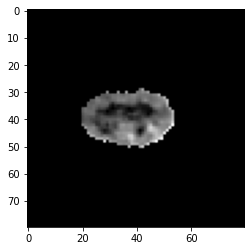

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(0,13):
    ## For L2 Distance
    frames.append([plt.imshow(train_y_np[0][0,:,:,i], cmap=cm.Greys_r,animated=True)])
    ## For Normal Image
    #frames.append([plt.imshow((a[:,:,i], cmap=cm.Greys_r,animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=120, blit=True, repeat_delay=1000)
ani.save('movie.mp4')

In [39]:
# 102.5 sec per sample/patient
# 
pred_np = pred.cpu().detach().numpy()
train_y_np = train_y.cpu().detach().numpy()
print_data_dimension(pred_np); print(type(pred_np))
print(pred_np[0].shape)
print_data_dimension(train_y_np); print(type(train_y_np))
print(train_y_np[0].shape)

(3, 1, 80, 80, 13)
<class 'numpy.ndarray'>
(1, 80, 80, 13)
(3, 1, 80, 80, 13)
<class 'numpy.ndarray'>
(1, 80, 80, 13)


### WASTE

###### LOSS

In [ ]:
# hidden = lambda c_in, c_out: Sequential(
#     Conv3d(c_in, c_out, (31,31,25)),
#     BatchNorm3d(c_out),
#     ReLU(),
#     MaxPool3d(1)
#     )
# Hidden = lambda c_in, c_out: Sequential(
#     Conv3d(c_in, c_out, (29,29,24)),
#     BatchNorm3d(c_out),
#     ReLU(),
#     MaxPool3d(1)
#     )
# hidden_1 = lambda c_in, c_out: Sequential(
#     Conv3d(c_in, c_out, (15,15,12)),
#     BatchNorm3d(c_out),
#     ReLU(),
#     MaxPool3d(1)
#     )
# hidden_2= lambda c_in, c_out: Sequential(
#     Conv3d(c_in, c_out, (13,13,14)),
#     BatchNorm3d(c_out),
#     ReLU(),
#     MaxPool3d(1)
#     )
# class Model_1(Module):
#     '''Class for the Model to be fitted on MRI data'''
#     def __init__(self, c):
#         '''Intiallizing the layers of the Model'''
#         super(Model_1, self).__init__();
#         self.hidden1 = hidden_1(1,c);
#         self.hidden2 = hidden_1(c,2*c);
#         self.hidden3 = hidden_1(2*c,4*c);
#         self.hidden4 = hidden_1(4*c,8*c);
#         self.hidden5 = hidden_1(8*c,16*c);
#         self.hidden6 = hidden_1(16*c,8*c);
#         self.hidden7 = hidden_1(8*c,8*c);
#         self.hidden8 = hidden_1(8*c,8*c);
#         self.hidden9 = hidden_1(8*c,8*c);
#         self.hidden10= hidden_1(8*c,8*c);
#         self.hidden11= hidden_1(8*c,4*c);
#         self.hidden12= hidden_1(4*c,4*c);
#         self.hidden13= hidden_1(4*c,2*c);
#         self.hidden14= hidden_1(2*c,c);
#         self.hidden15= hidden_2(c,1);
#     def forward(self, x):
#         '''Implements the forward pass of the Network'''
#         x = self.hidden1(x)
#         x = self.hidden2(x)
#         x = self.hidden3(x)
#         x = self.hidden4(x)
#         x = self.hidden5(x)
#         x = self.hidden6(x)
#         x = self.hidden7(x)
#         x = self.hidden8(x)
#         x = self.hidden9(x)
#         x = self.hidden10(x)
#         x = self.hidden11(x)
#         x = self.hidden12(x)
#         x = self.hidden13(x)
#         x = self.hidden14(x)
#         x = self.hidden15(x)
#         return x 

# channels = 1; #3 Defining the number od channels we have for neural network
# # Intializing model
# model = Model_1(channels).to(device) # Intializing the model 
# summary(model,(1, 288, 288, 180))

In [30]:
def mse(y_t , y_p):
    ## To calculate the mean square error
    print(y_t.shape); print(y_p.shape); 
    ## Normal Mean Square Error - reduce( x+y , (y_t - y_p)^2)
    loss = torch.sum(torch.square(torch.flatten(y_t) - torch.flatten(y_p)))/len(torch.flatten(y_t))
    return loss
print(mse(pred,train_y))

torch.Size([3, 1, 80, 80, 13])
torch.Size([3, 1, 80, 80, 13])
tensor(0.5570, device='cuda:0', grad_fn=<DivBackward0>)


In [8]:
input  = 180 ; output = 13 ; kernel = 12 ; ctr = 0;

while(input >= output):
    input = input - kernel; ctr = ctr+1;

print(ctr)
print(input)
#kernel lenght and breadth = 15,layers -> 14 X height = 12,layers -> 14 

14
12


##### Training



In [ ]:
## Go with Lazy 3D convs LAZYCONV3Dw

## The loss function to get the result
class Normal_3D_cnn(Module):   
    
    def __init__(self):
        super(Normal_3D_cnn, self).__init__()
        
        self.cnn_layers = Sequential(
            # Defining a 3D convolution layer
            LazyConv3d(1, kernel_size= 3, stride=1, padding=1),
            BatchNorm3d(1),
            ReLU(inplace=True),
            MaxPool3d(kernel_size=2, stride=2),
            # # Defining another 3D convolution layer
            # LazyConv3d(1,kernel_size=3, stride=1, padding=1),
            # BatchNorm3d(1),
            # ReLU(inplace=True),
            # MaxPool3d(kernel_size=2, stride=2),
        )
    def forward(self, x):
        x = self.cnn_layers(x)
        return x

model = Normal_3D_cnn()
print(model)
optimizer = Adam(model.parameters(), lr=0.07)

def train():
    model.train()
    optimizer.zero_grad()
    y_p = model(x[0])
    loss = mse(y[0],y_p)
    return loss, y_p

loss,y_p = train()
print(loss,y_p.shape)
